<a href="https://colab.research.google.com/github/AmitCosmo/hubble-data/blob/main/deceleration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm,uniform
import time
import corner
import math
import scipy.optimize as op
# from numpy import *

In [ ]:
x,y,yerr = np.loadtxt('https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/H_46%20%20data%20set.txt', unpack=True)

In [ ]:
#Initial seeds
h0_ini,q0_ini,q1_ini=70,0,0

#Define log-Likelihood Function

def likelihood(theta, x, y, yerr):
    h0, q0, q1 = theta
    model = h0 * (1 + x) ** (1 + q0) * np.exp(q1 * (np.sqrt(1 + x**2) - 1))
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(6.28*inv_sigma2)))

In [ ]:
#Define Prior Function
def prior(theta):
    h0, q0, q1= theta
    if 0< h0 < 100.0 and -2.0 < q0 < 2.0 and 0.0 < q1 < 2.0:
        return 0.0
    return -np.inf

#Degine Posterior Function
def posterior(theta, x, y, yerr):
    lp = prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp + likelihood(theta, x, y, yerr))

In [ ]:
#Define number of parameter, steps, burn-in phase
ndim=3
nsteps=300000
nburn_in=1000

initials=h0_ini,q0_ini,q1_ini

In [ ]:
start_time = time.time()


#Define Metropolis-Hastings Function
def Metropolis_Hastings(parameter_init, iteration_time):
    result = []
    result.append(parameter_init)
    for t in range(iteration_time):
        step_var = [1, 0.01, 0.06]
        proposal = np.zeros(3)
        for i in range(3):
            proposal[i] = norm.rvs(loc=result[-1][i], scale=step_var[i])
            probability = np.exp(posterior(proposal,x,y,yerr) - posterior(result[-1],x,y,yerr))
            if (uniform.rvs() < probability):
                result.append(proposal)
            else:
                result.append(result[-1])
    return (result)

result = Metropolis_Hastings(initials, nsteps)

result = result[nburn_in:]
a_result = np.zeros(nburn_in)
b_result = np.zeros(nburn_in)
samples_MH=np.array(result)
h0_mcmc, q0_mcmc, q1_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples_MH,
                       [16, 50, 84],axis=0)))

print("----------------------------------------------------------------------\n")
print("Execution time with steps=%s------> %6.3f seconds" %
      (nsteps,(time.time() - start_time)))
print("----------------------------------------------------------------------\n")

----------------------------------------------------------------------

Execution time with steps=300000------> 140.931 seconds
----------------------------------------------------------------------



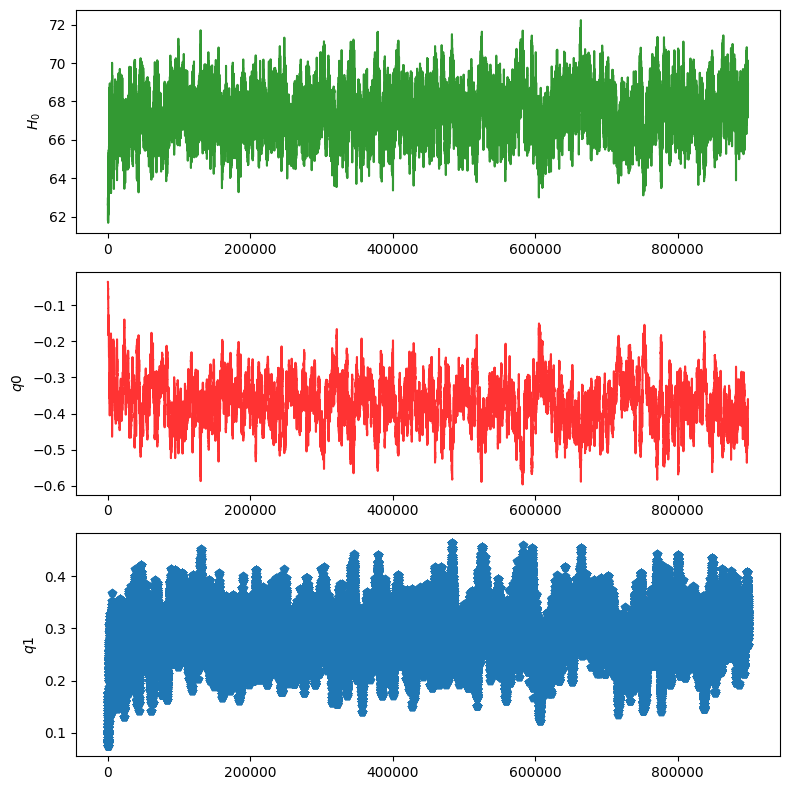

In [ ]:
# Plot the traceplots of the MCMC chains
fig, axes = plt.subplots(3, 1, figsize=(8, 8))
samples = samples_MH.T

# Plot the traceplot of H0
axes[0].plot(samples[0], "g", alpha=0.8)
axes[0].set_ylabel("$H_0$")


# Plot the traceplot of q0
axes[1].plot(samples[1], "r", alpha=0.8)
axes[1].set_ylabel("$q0$")

# Plot the traceplot of q1
axes[2].plot(samples[2], "p", alpha=0.8)
axes[2].set_ylabel("$q1$")

plt.tight_layout()
# plt.savefig("FLCDM_H_31_MH_traces.png")
plt.show()

In [ ]:
print("""MCMC result:
    H_0 = {0[0]} +{0[1]} -{0[2]}
    q_0 = {2[0]} +{2[1]} -{2[2]}
    q_1 = {4[0]} +{4[1]} -{4[2]}
""".format(h0_mcmc, h0_ini, q0_mcmc, q0_ini, q1_mcmc, q1_ini))

MCMC result:
    H_0 = 67.3733822012096 +1.187737099529187 -1.1675725798833412
    q_0 = -0.36999460240272103 +0.06363635408513402 -0.06841661419133638
    q_1 = 0.2896812482565982 +0.046902874014017826 -0.04513241983201963



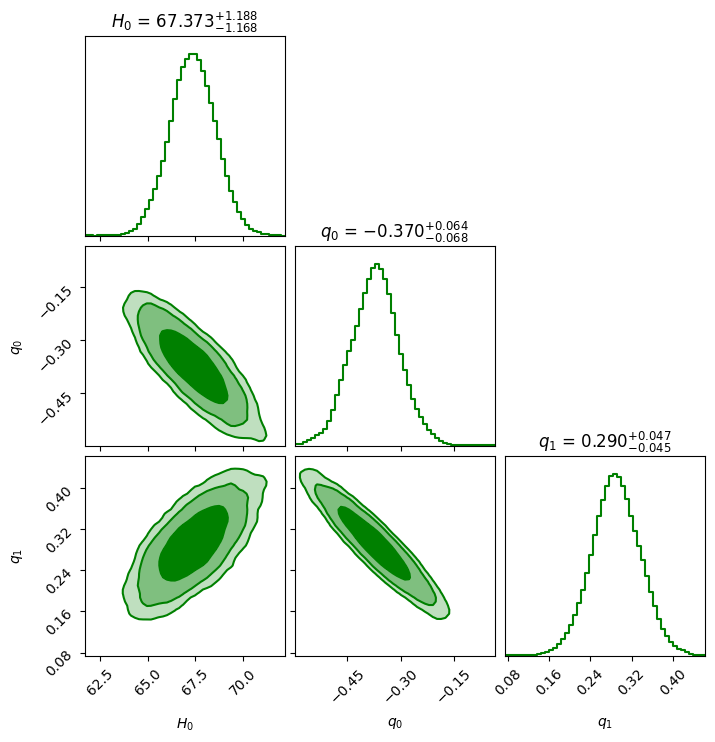

In [ ]:
fig = corner.corner(samples_MH,bins=50,color="g",labels=["$H_0$","$q_0$", "$q_1$"],
                    fill_contours=True,
                    levels=(0.68,0.95,0.99,),
                    title_fmt='.3f',plot_datapoints=False,smooth=True, smooth1d=True, smooth3d=True, show_titles=True, plot_contours=True)
#fig.savefig("FLCDM_H_46_MH.png")

In [ ]:
!pip install lmfit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from lmfit import Model
import matplotlib.pyplot as plt

# Load the Hubble dataset with errors (z: redshift, H: Hubble parameter, err: error)
data = np.loadtxt('https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/H_46%20%20data%20set.txt', unpack=True)

z = data[0]
H = data[1]
err = data[2]

# Define the function to be fitted
def hubble_func(z, h0, q0, q1):
    return h0 * (1 + z) ** (1 + q0) * np.exp(q1 * (np.sqrt(1 + z**2) - 1))

# Create an lmfit Model object
model = Model(hubble_func)

# Set initial parameter values
params = model.make_params(h0=70, q0=0, q1=0)

# Perform the fit
result = model.fit(H, params, z=z, weights=1/err)

# Get the best-fit parameters
best_fit_parameters = result.params

# Print the best-fit parameters
print("Best-fit Parameters:")
print("h0 =", best_fit_parameters['h0'].value)
print("q0 =", best_fit_parameters['q0'].value)
print("q1 =", best_fit_parameters['q1'].value)


Best-fit Parameters:
h0 = 67.42215465195015
q0 = -0.3743888060447666
q1 = 0.2927047558270248


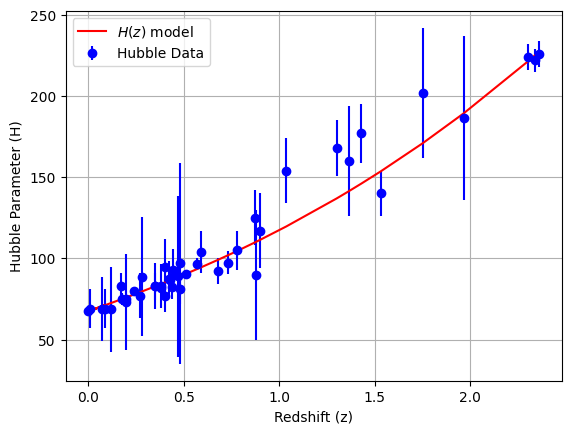

In [ ]:
# Plot the data with error bars
plt.errorbar(z, H, yerr=err, fmt='bo', label='Hubble Data')

# Generate the predicted values from the best-fit parameters
predicted_H = model.eval(best_fit_parameters, z=z)

# Plot the best-fit line
plt.plot(z, predicted_H, 'r-', label='$H(z)$ model')

# Add labels and legend
plt.xlabel('Redshift (z)')
plt.ylabel('Hubble Parameter (H)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()